In [47]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from data_loader.dataLoader import KaggleLoader

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

%matplotlib inline

### Data Loading

In [2]:
# Loading sample datasets from Kaggle
loader = KaggleLoader("joonasyoon/clustering-exercises")

df_blob = loader.load_csv("blob.csv")
df_dart = loader.load_csv("dart.csv")
df_outliers = loader.load_csv("outliers.csv")
df_spiral2 = loader.load_csv("spiral2.csv")
df_basic2 = loader.load_csv("basic2.csv")
df_boxes3 = loader.load_csv("boxes3.csv")

# Loading online retail dataset
OR_loader = KaggleLoader("hellbuoy/online-retail-customer-clustering")
df_onlineRetail = OR_loader.load_csv_with_encoding("OnlineRetail.csv", 
                                                   encoding = "unicode_escape"
)
df_onlineRetail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


### EDA

#### Descriptive statistics

In [3]:
# Checking the shape, data types, and missing values
print(df_onlineRetail.shape)
print(df_onlineRetail.info())
df_onlineRetail.isnull().sum()

(541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
# Numerical summary of the data
df_onlineRetail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


negative values are probably representing returns.

In [5]:
# Converting InvoiceDate to datetime object
df_onlineRetail['InvoiceDate'] = pd.to_datetime(df_onlineRetail['InvoiceDate'], format="%d-%m-%Y %H:%M")
print(f"The data period spans from {df_onlineRetail["InvoiceDate"].min()} to {df_onlineRetail["InvoiceDate"].max()}")

# Converting CustomerID column into int
df_onlineRetail['CustomerID'] = df_onlineRetail['CustomerID'].astype('Int64')

# Nb of unique customers
print(f"Nb. of unique customers: {df_onlineRetail['CustomerID'].nunique()}")

# Transactions per customer to identify loyal customers
df_onlineRetail.groupby('CustomerID').agg({'InvoiceNo': 'nunique'}).sort_values(by='InvoiceNo', ascending=False)

The data period spans from 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Nb. of unique customers: 4372


,InvoiceNo
CustomerID,
14911,248
12748,224
17841,169
14606,128
13089,118
...,...
13877,1
16400,1
13878,1


In [6]:
# The count of countries in the dataset
df_onlineRetail.groupby('Country').agg({'InvoiceNo': 'count'}).sort_values(by='InvoiceNo', ascending=False).head(10)

,InvoiceNo
Country,
United Kingdom,495478
Germany,9495
France,8557
EIRE,8196
Spain,2533
Netherlands,2371
Belgium,2069
Switzerland,2002
Portugal,1519


In [7]:
# Checking quantities with negative values
df_onlineRetail.loc[df_onlineRetail['Quantity']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom


InvoiceNo starting with 'C' represents cancelled transactions.

In [8]:
# Checking unit price with negative values
df_onlineRetail.loc[df_onlineRetail['UnitPrice']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,<NA>,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,<NA>,United Kingdom


### Data Cleansing

In [9]:
# Dropping the missing rows on CustomerID column
df_onlineRetail = df_onlineRetail.dropna(subset=['CustomerID'], how='any', ignore_index=True)

# Dropping cancellations from the dataset
print(f"Nb. of rows with negative quantities: {int(df_onlineRetail.loc[df_onlineRetail['Quantity'] < 0, 'InvoiceNo'].count())}")
df_onlineRetail = df_onlineRetail.loc[~df_onlineRetail['InvoiceNo'].astype('str').str.startswith('C')]

# Dropping rows with negative unit prices
print(f"Nb. of rows with negative unit prices: {int(df_onlineRetail.loc[df_onlineRetail['UnitPrice'] < 0, 'InvoiceNo'].count())}")
df_onlineRetail = df_onlineRetail.loc[df_onlineRetail['UnitPrice'] >= 0]

# Dropping any duplicate rows 
df_onlineRetail = df_onlineRetail.drop_duplicates().reset_index(drop=True)

print(f"The shape of the dataset after data cleansing step: {df_onlineRetail.shape}")


Nb. of rows with negative quantities: 8905
Nb. of rows with negative unit prices: 0
The shape of the dataset after data cleansing step: (392732, 8)


#### RFM Feature Engineering

RFM feature engineering step turns the transaction-level data into customer-lever features. 

R: Recency -> how recently a customer purchased

F: Frequency -> how often a customer purchased

M: Monetary -> how much a customer spent

In [10]:
# Generating TotalPrice column
df_onlineRetail['TotalPrice'] = df_onlineRetail['Quantity'] * df_onlineRetail['UnitPrice']

# The date of analysis
report_date = df_onlineRetail['InvoiceDate'].max() + pd.Timedelta(days=1)

# Data aggregation over RFM metrics
rfm = df_onlineRetail.groupby('CustomerID').agg({
    'InvoiceDate': lambda t: (report_date - t.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})
rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'}, inplace = True)

# Dropping zero-monetary customers
rfm = rfm.loc[rfm['Monetary'] > 0]
print(rfm.describe())
rfm

           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422     4.272706    2048.688081
std     100.014169     7.706221    8985.230220
min       1.000000     1.000000       3.750000
25%      18.000000     1.000000     306.482500
50%      51.000000     2.000000     668.570000
75%     142.000000     5.000000    1660.597500
max     374.000000   210.000000  280206.020000


,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40
...,...,...,...
18280,278,1,180.60
18281,181,1,80.82
18282,8,2,178.05


#### Outlier Detection

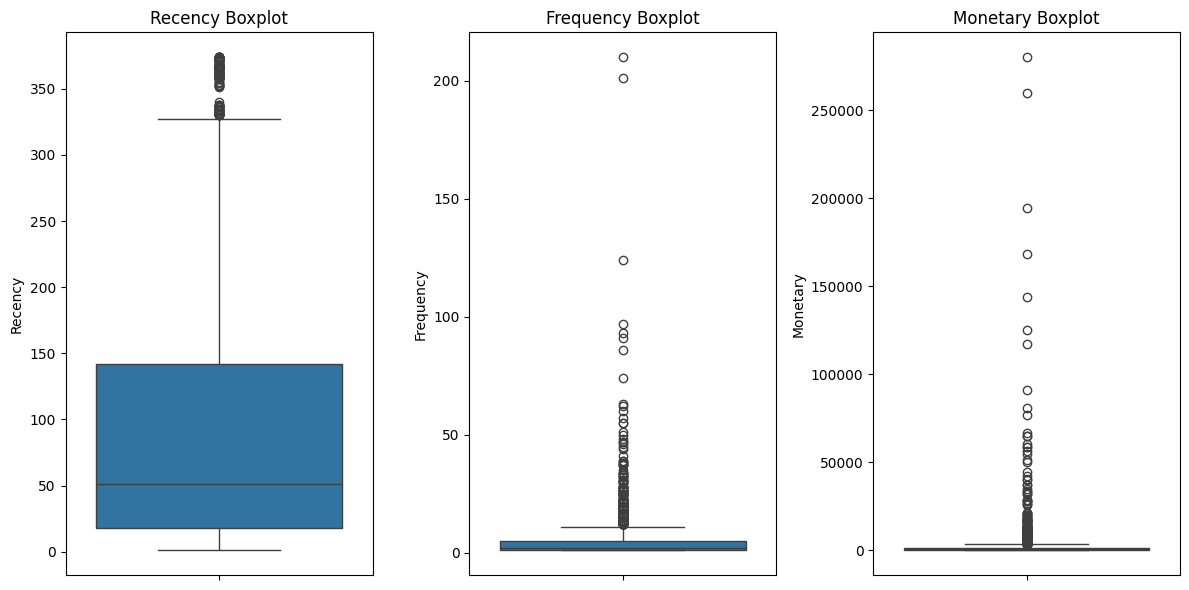

In [11]:
# Boxplot Visualization
fig, ax = plt.subplots(1, 3, figsize = (12,6))

sns.boxplot(y = rfm['Recency'], ax = ax[0])
ax[0].set_title('Recency Boxplot')
sns.boxplot(y = rfm['Frequency'], ax = ax[1])
ax[1].set_title('Frequency Boxplot')
sns.boxplot(y = rfm['Monetary'], ax = ax[2])
ax[2].set_title('Monetary Boxplot')

plt.tight_layout()
plt.show()

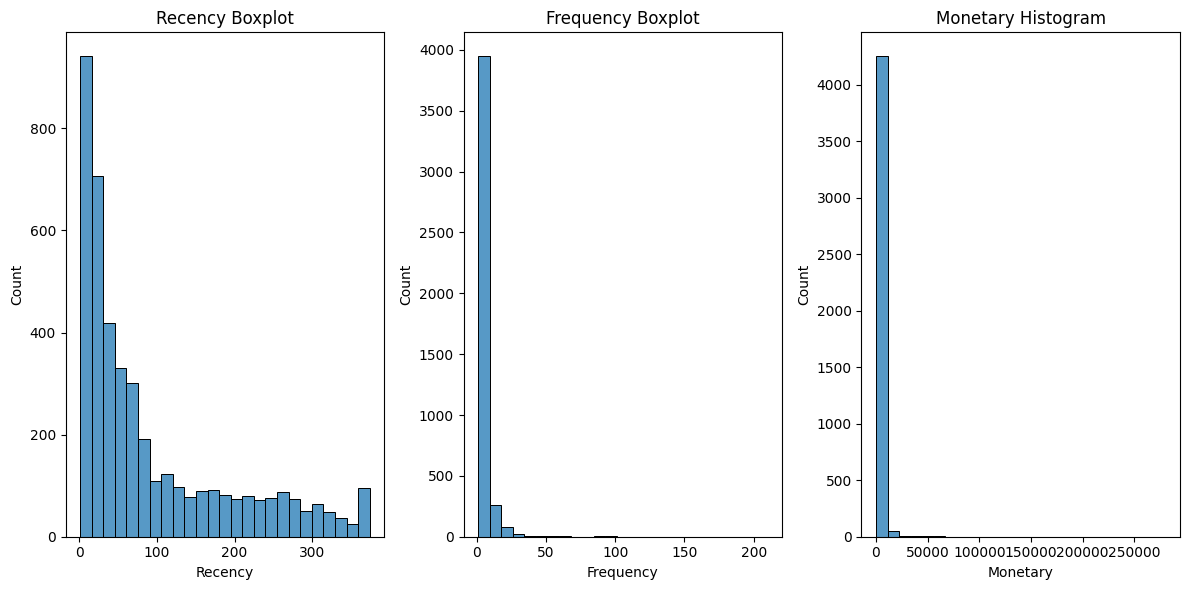

In [12]:
# Histogram Visualization
fig, ax = plt.subplots(1, 3, figsize = (12,6))

sns.histplot(x = rfm['Recency'], bins = 25, ax = ax[0])
ax[0].set_title('Recency Boxplot')
sns.histplot(x = rfm['Frequency'], bins = 25, ax = ax[1])
ax[1].set_title('Frequency Boxplot')
sns.histplot(x = rfm['Monetary'], bins = 25, ax = ax[2])
ax[2].set_title('Monetary Histogram')

plt.tight_layout()
plt.show()

The distributions are not normal, and highly skewed. We also observe on boxplots that there are many outliers in the dataset.

In [35]:
# Using Isolation Forest as an Outlier Detection Algorithm
rfm_if = rfm.copy()

# Log transformation
rfm_if['Recency'] = np.log1p(rfm_if['Recency'])
rfm_if['Frequency'] = np.log1p(rfm_if['Frequency'])
rfm_if['Monetary'] = np.log1p(rfm_if['Monetary'])

# Fitting Isolation Forest
iso_forest = IsolationForest(
    n_estimators = 150,
    contamination = 0.10,
    random_state = 7
) # we assume that almost 10% of the data is composed by outliers

rfm_if['Outlier'] = iso_forest.fit_predict(rfm_if)
print(rfm_if['Outlier'].value_counts())
rfm_if

Outlier
 1    3904
-1     434
Name: count, dtype: int64


,Recency,Frequency,Monetary,Outlier
CustomerID,,,,
12346,5.789960,0.693147,11.253955,-1
12347,1.098612,2.079442,8.368925,1
12348,4.330733,1.609438,7.494564,1
12349,2.995732,0.693147,7.472245,1
12350,5.739793,0.693147,5.815324,1
...,...,...,...,...
18280,5.631212,0.693147,5.201806,1
18281,5.204007,0.693147,4.404522,1
18282,2.197225,1.098612,5.187665,1


Returns -1 for outliers, while 1 for inliers

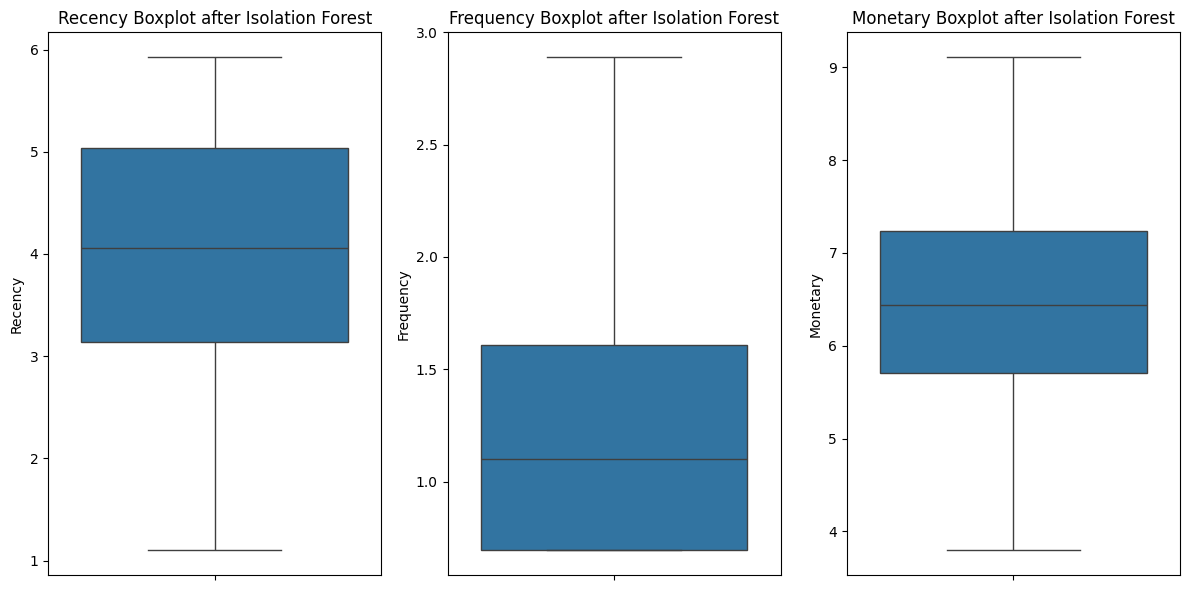

In [36]:
# Dropping the outliers
rfm_clean = rfm_if.loc[rfm_if['Outlier'] == 1].drop(columns=['Outlier'])

# Boxplot Visualization after outlier removal
fig, ax = plt.subplots(1, 3, figsize = (12,6))

sns.boxplot(y = rfm_clean['Recency'], ax = ax[0])
ax[0].set_title('Recency Boxplot after Isolation Forest')
sns.boxplot(y = rfm_clean['Frequency'], ax = ax[1])
ax[1].set_title('Frequency Boxplot after Isolation Forest')
sns.boxplot(y = rfm_clean['Monetary'], ax = ax[2])
ax[2].set_title('Monetary Boxplot after Isolation Forest')

plt.tight_layout()
plt.show()


#### Scaling the Data

We will apply RobustSclaer due to the anomalies in the dataset.

In [45]:
# RobustScaler
scl = RobustScaler()
rfm_scaled = scl.fit_transform(
    rfm_clean[['Recency', 'Frequency', 'Monetary']]
)
rfm_scaled = pd.DataFrame(
    rfm_scaled,
    index = rfm_clean.index,
    columns = ['Recency', 'Frequency', 'Monetary']
)
rfm_scaled

,Recency,Frequency,Monetary
CustomerID,,,
12347,-1.556338,1.070435,1.272520
12348,0.142028,0.557493,0.697577
12349,-0.559468,-0.442507,0.682901
12350,0.882440,-0.442507,-0.406620
12352,-0.236210,1.198978,0.916080
...,...,...,...
18278,0.135068,-0.442507,-0.834762
18280,0.825384,-0.442507,-0.810043
18281,0.600903,-0.442507,-1.334304


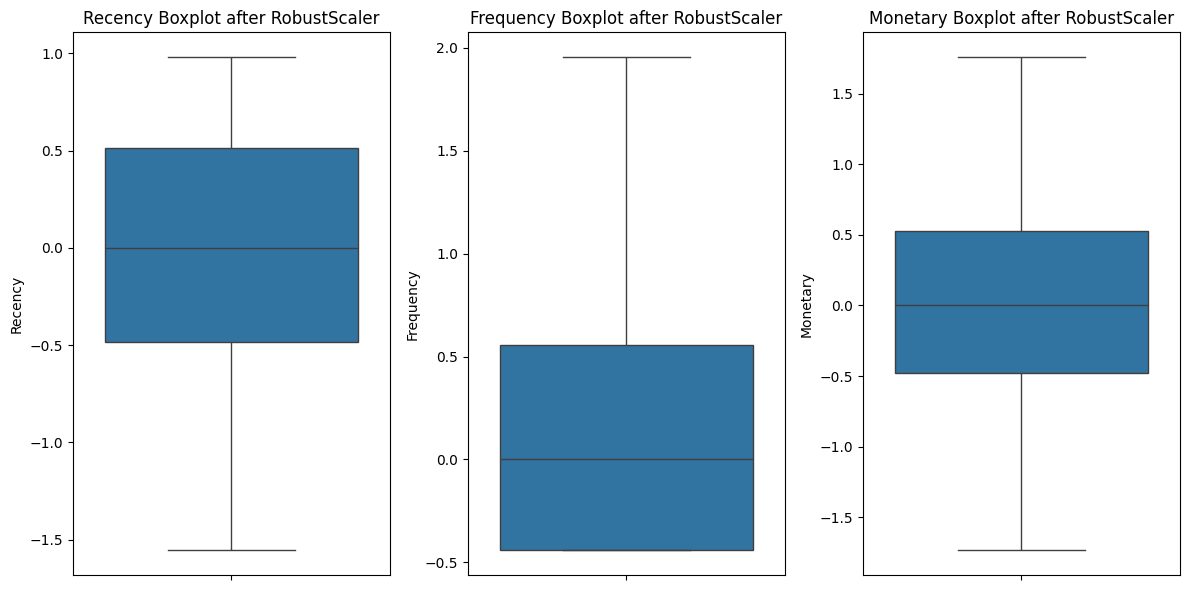

In [ ]:
# Boxplot Visualization after RobustScaler
fig, ax = plt.subplots(1, 3, figsize = (12,6))

sns.boxplot(y = rfm_scaled['Recency'], ax = ax[0])
ax[0].set_title('Recency Boxplot after RobustScaler')
sns.boxplot(y = rfm_scaled['Frequency'], ax = ax[1])
ax[1].set_title('Frequency Boxplot after RobustScaler')
sns.boxplot(y = rfm_scaled['Monetary'], ax = ax[2])
ax[2].set_title('Monetary Boxplot after RobustScaler')

plt.tight_layout()
plt.show()